In [1]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
import pandas as pd
import sklearn
import datetime
%matplotlib inline

# Import and process data

In [2]:
def importData(filepath):
    ppt = np.genfromtxt(filepath)
    dppt = np.diff(np.transpose(ppt)) 
    print("Shape:", dppt[1:16,:].shape)
    return dppt[1:16,:]

illPat0 = importData("./inData/clean_ecg/ill/s0067lre.txt")
illPat1 = importData("./inData/clean_ecg/ill/s0080lre.txt")
illPat2 = importData("./inData/clean_ecg/ill/s0081lre.txt")
illPat3 = importData("./inData/clean_ecg/ill/s0039lre.txt")
illPat4 = importData("./inData/clean_ecg/ill/s0044lre.txt")
illPat5 = importData("./inData/clean_ecg/ill/s0049lre.txt")
illPat6 = importData("./inData/clean_ecg/ill/s0174lre.txt")

healthPat0 = importData("./inData/clean_ecg/health/s0303lre.txt")
healthPat1 = importData("./inData/clean_ecg/health/s0306lre.txt")
healthPat2 = importData("./inData/clean_ecg/health/s0302lre.txt")
healthPat3 = importData("./inData/clean_ecg/health/s0543_re.txt")
healthPat4 = importData("./inData/clean_ecg/health/s0551_re.txt")
healthPat5 = importData("./inData/clean_ecg/health/s0552_re.txt")

    
healthPat = np.hstack(np.concatenate((healthPat0, healthPat1, healthPat2, healthPat3, healthPat4, healthPat5), axis=1))
illPat = np.hstack(np.concatenate((illPat0, illPat1, illPat2, illPat3, illPat4, illPat5, illPat6), axis=1))
print(healthPat.shape, illPat.shape)

Shape: (15, 31999)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 115199)
Shape: (15, 120011)
Shape: (15, 120011)
Shape: (15, 120011)
(10584450,) (10847895,)


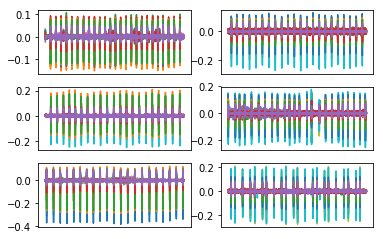

In [3]:
# Various plots...
fig, ((a,b),(c,d),(e,f)) = plt.subplots(3,2)
for i in np.arange(0,15):
    a.plot(healthPat0[i,0:20000])
    a.set_xticks([])
for i in np.arange(0,15):
    b.plot(illPat0[i,0:20000])
    b.set_xticks([])
for i in np.arange(0,15):
    c.plot(healthPat1[i,0:20000])
    c.set_xticks([])
for i in np.arange(0,15):
    d.plot(illPat1[i,0:20000])
    d.set_xticks([])
for i in np.arange(0,15):
    e.plot(healthPat2[i,0:20000])
    e.set_xticks([])
for i in np.arange(0,15):
    f.plot(illPat2[i,0:20000])
    f.set_xticks([])

In [179]:
def findAbove(arr, threshold, skip):
    """
    Return indices for values above threshhold in array, arr. Keep only first items in sequence.
    """
    inlst = []
    for index, item in enumerate(arr):
        if item >= threshold:
            inlst.append(index)
            
    return inlst[::skip]

def getSamples(arr, peakArr, buffer, shift):
    """
    Get samples for array arr shifted by shift amount, with buffer each side of peak indices, in peakArr.
    """
    sampledData = []
    for i in peakArr:
        if len(arr[i-buffer: i+buffer]) == buffer*2: # Check that all samples are same size
            sampledData.append(arr[i-buffer+shift: i+buffer+shift])
        
    return sampledData

def shuffle2Lst(list1, list2):
    """ 
    Shuffle two lists in similar ways.
    """
    list1_shuf = []
    list2_shuf = []
    index_shuf = np.arange(len(list1))
    shuffle(index_shuf)
    for i in index_shuf:
        list1_shuf.append(list1[i])
        list2_shuf.append(list2[i])
    return list1_shuf, list2_shuf

def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def visualiseData(ecgData, classData, gridSize, axis):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-16)
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].plot(ecgData[r+k])
            if axis == False:
                ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def undiff(ecgData, buffer):
    """
    Reverse the differentiation done earlier through np.cumsum.
    """
    ecgData = np.reshape(ecgData, (ecgData.shape[0], buffer*2))
    for i in np.arange(0,ecgData.shape[0], 1):
        ecgData[i] = np.cumsum(ecgData[i])
    ecgData = np.reshape(ecgData, (ecgData.shape[0], buffer*2, 1))
    return ecgData            
            
def functionTown(illArr, healthArr, illThreshold, healthThreshold, skip, shift, buffer, shuffle):
    """
    Return the processed ecgData and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data.
    """
    illPeakArr = findAbove(np.abs(illArr), illThreshold, skip)
    illSampled = getSamples(illArr, illPeakArr, buffer, shift)
    healthPeakArr = findAbove(np.abs(healthArr), healthThreshold, skip)
    healthSampled = getSamples(healthArr, healthPeakArr, buffer, shift)
    
    print("ill samples", len(illSampled))
    print("healthy samples", len(healthSampled))
    
    classData = []
    for i in np.arange(0, len(illSampled), 1):
        classData.append(1)
    for i in np.arange(0, len(healthSampled), 1):
        classData.append(0)
    ecgData = illSampled + healthSampled
    
    if shuffle == True:
        classData, ecgData = shuffle2Lst(classData, ecgData)
        
    classDataOH = processClassData(classData)
    
    ecgData = np.reshape(np.concatenate(ecgData, axis=0), [-1, buffer*2, 1])
    
    return ecgData, classDataOH, classData
    
buffer = 300
healthThreshold = 0.08
illThreshold = 0.08
skip = 15
shift = 0
shuf = True

ecgData, classDataOH, classData = functionTown(illPat, healthPat, illThreshold, healthThreshold, skip,\
                                               shift, buffer, shuf)
# Reintegrate the found values...
ecgData = undiff(ecgData, buffer)
# Take 20% for testing later:
testData = ecgData[:round(ecgData.shape[0]*0.2)]
trainData = ecgData[round(ecgData.shape[0]*0.2):]
testLabels = classDataOH[:round(ecgData.shape[0]*0.2)]
trainLabels = classDataOH[round(ecgData.shape[0]*0.2):]

ill samples 4475
healthy samples 7028


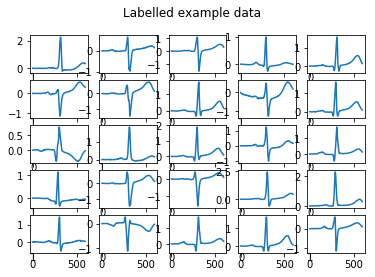

In [180]:
visualiseData(ecgData, classData, 5, True)
#plt.savefig("./outData/figures/exampleDataECGundiff.pdf")

# Neural Network

In [181]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, buffer*2, 1])
    
# First layer:
net = tflearn.layers.conv.conv_1d(net, 32, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Second layer:
net = tflearn.layers.conv.conv_1d(net, 64, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_1d(net, 2)

# Fully connected layer 1:
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                         learning_rate=0.00001)

In [182]:
model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(trainData, trainLabels, n_epoch=20, show_metric=True)

Training Step: 2880  | total loss: 0.05878
| Adam | epoch: 020 | loss: 0.05878 - acc: 0.9816 -- iter: 9202/9202
Training Step: 2880  | total loss: 0.05878
| Adam | epoch: 020 | loss: 0.05878 - acc: 0.9816 -- iter: 9202/9202
--


In [184]:
# Save model?
#now = datetime.datetime.now()
#model.save("./outData/models/cleanECG_undiff_20e_300buff_0shift_"+now.isoformat()+"_.tflearn")

# Test accuracy of model(s)

In [185]:
#model.load("./outData/models/cleanECG_undiff_unabs_2017-02-20T12:26:25.854019_.tflearn")
labellst = classData[:round(ecgData.shape[0]*0.2)]
healthTest = []
illTest = []
for index, item in enumerate(labellst):
    if item == 1:
        illTest.append(testData[index])
    if item == 0:
        healthTest.append(testData[index])

healthLabel = np.tile([1,0], (len(healthTest), 1))
illLabel = np.tile([0,1], (len(illTest), 1))
                      
print("Sensitivity:", model.evaluate(np.array(healthTest), healthLabel), "Specifity:",\
    model.evaluate(np.array(illTest), illLabel),\
    "Accuracy:", model.evaluate(testData, testLabels))

Sensitivity: [0.988834612700628] Specifity: [0.98156682027649766] Accuracy: [0.98609300304215564]


### What if the model hasn't seen data from the patient?

In [186]:
till = np.hstack(importData("./inData/clean_ecg/ill/s0177lre.txt"))
thealth = np.hstack(importData("./inData/clean_ecg/health/s0287lre.txt"))

tillarr, tillclassOH, tillclassData = functionTown(till, [0], illThreshold, healthThreshold, \
                                                   skip, shift, buffer, shuf)
thealtharr, thealthclassOH, thealthclassData = functionTown([0], thealth, illThreshold, \
                                                            healthThreshold, skip, shift, buffer, shuf)
# Undifferentiate values
tillarr = undiff(tillarr, buffer)
thealtharr = undiff(thealtharr, buffer)
sens = model.evaluate(thealtharr, thealthclassOH)[0]
spec = model.evaluate(tillarr, tillclassOH)[0]

print("Sensitivity:", sens,\
      "Specifity:", spec,\
      "Accuracy:", ((sens+spec)/2.0))

Shape: (15, 115199)
Shape: (15, 115199)
ill samples 682
healthy samples 0
ill samples 0
healthy samples 1622
Sensitivity: 0.92478421753 Specifity: 0.93401759356 Accuracy: 0.929400905545
